In [1]:
import pandas as pd

train_df = pd.read_csv('./data/toxic_train.csv')
test_df = pd.read_csv('./data/toxic_test.csv')

In [2]:
train_df = train_df.drop(columns=['Unnamed: 0'])
train_df

,comment_text,toxic
0,Explanation\r\nWhy the edits made under my use...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \r\n\r\nThat...,0
159568,"Spitzer \r\n\r\nUmm, theres no actual article ...",0
159569,And it looks like it was actually you who put ...,0


In [3]:
test_df = test_df.drop(columns=['Unnamed: 0'])
test_df

,comment_text,toxic
0,Thank you for understanding. I think very high...,0
1,:Dear god this site is horrible.,0
2,"""::: Somebody will invariably try to add Relig...",0
3,""" \r\n\r\n It says it right there that it IS a...",0
4,""" \r\n\r\n == Before adding a new product to t...",0
...,...,...
63973,":Jerome, I see you never got around to this…! ...",0
63974,==Lucky bastard== \r\n http://wikimediafoundat...,0
63975,==shame on you all!!!== \r\n\r\n You want to s...,0
63976,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1


## Preprocessing

In [4]:
# selecting text data

train_df = train_df.sample(frac=1) #shuffling the training dataset
train = train_df['comment_text']
train = train.to_list()
train[:10]

['"\r\n\r\n WP:AWB \r\n\r\nYou already seem to be approved for this; I would have done so anyhow. andemu "',
 "Danica Patrick's origin isn't from a video game. \r\n\r\nIf Cyberlink420, or anybody else, has proof that she originates from a video game, please provide a citation. Thank you. 118.21.142.128",
 "STOP editing and creating pages in Monterey County, California\r\nPlease stop creating new stu for nonfor non-existant, unlocatable locations, including Animpa|Amo, [[Esl, Eslanagan, Californiagan, n, Gurnia|G, [[Kak, Kakonkaruk, k, Kalindaruk, Kulul, Lukaiasta, Paisin, Quina, Sapaywis, Seama, Soccorondo, Steloglamo, Subazama, Tecolom, Teshaya, Tetachoya, Tiubta, Wachanaruka, Zassalete and Zumblito. These locations could be listed in an article on native Indian sites of Monterey County, but to create 21 stubs that reference no other related articles and are not themselves referenced by other articles creates a lot of wasted editing time for other editors.\r\n\r\nAlso, please read art

### Creating a transformer for preprocessing text data

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize

import re

# transformer class
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords, stemmer):
        super().__init__()
        self.stopwords = stopwords
        self.stemmer = stemmer
        self.hapaxes = []
        self.named_entities = []
    
    # by default a transformer's fit method just returns self
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for i, sample in enumerate(X):
            X[i] = self.__normalize(sample)
            X[i] = self.__eliminate_stopwords(X[i])
            X[i] = self.__get_hapaxes(X[i])
            X[i] = self.__stem(X[i])
            self.__named_entity_extraction(X[i])
        
        return X

    def __normalize(self, text):
        return ' '.join(re.findall('[a-zA-Z]+', text.lower().replace(r'\r', ' ').replace(r'\n', ' ')))
    
    def __eliminate_stopwords(self, text):
        if self.stopwords is not None:
            return ''.join([word for word in text if word not in self.stopwords])
    
    def __get_hapaxes(self, text, eliminate=True):
        fd = FreqDist(word_tokenize(text))
        self.hapaxes.append(fd.hapaxes())
                       
        if eliminate:
            text = ''.join([word for word in text if word not in self.hapaxes])
        
        return text
    
    def __stem(self, text):
        return ' '.join([self.stemmer.stem(word) for word in word_tokenize(text)])
    
    def __named_entity_extraction(self, text):
        for sent in sent_tokenize(text):
            for chunk in nltk.ne_chunk(nltk.pos_tag(word_tokenize(sent))):
                if hasattr(chunk, 'label'):
                    self.named_entities.append(chunk)

### Using the transformer to preprocess the training text

In [6]:
from nltk.stem import PorterStemmer

transformer = TextTransformer(stopwords=['and', 'for', 'in', 'about', 'for', 'as', 'the'], stemmer=PorterStemmer())

In [7]:
train = transformer.transform(train[:1024])
train[:10]

['wp awb you alreadi seem to be approv for thi i would have done so anyhow andemu',
 'danica patrick s origin isn t from a video game if cyberlink or anybodi els ha proof that she origin from a video game pleas provid a citat thank you',
 'stop edit and creat page in monterey counti california pleas stop creat new stu for nonfor non exist unlocat locat includ animpa amo esl eslanagan californiagan n gurnia g kak kakonkaruk k kalindaruk kulul lukaiasta paisin quina sapaywi seama soccorondo steloglamo subazama tecolom teshaya tetachoya tiubta wachanaruka zassalet and zumblito these locat could be list in an articl on nativ indian site of monterey counti but to creat stub that refer no other relat articl and are not themselv referenc by other articl creat a lot of wast edit time for other editor also pleas read articl that you add inform to like you had fail to do befor edit spreckel california by ad info that wa alreadi note elsewher in the articl it appear as though you have acquir a ne

## Choosing the model

The plan is to test the accuracy of different models on the same dataset.

In [18]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler

### The training dataset

In [19]:
X = pd.DataFrame(train, columns=['text']).dropna()['text'].values
y = train_df[:1024]['toxic'].dropna().values
X, y

(array(['wp awb you alreadi seem to be approv for thi i would have done so anyhow andemu',
        'danica patrick s origin isn t from a video game if cyberlink or anybodi els ha proof that she origin from a video game pleas provid a citat thank you',
        'stop edit and creat page in monterey counti california pleas stop creat new stu for nonfor non exist unlocat locat includ animpa amo esl eslanagan californiagan n gurnia g kak kakonkaruk k kalindaruk kulul lukaiasta paisin quina sapaywi seama soccorondo steloglamo subazama tecolom teshaya tetachoya tiubta wachanaruka zassalet and zumblito these locat could be list in an articl on nativ indian site of monterey counti but to creat stub that refer no other relat articl and are not themselv referenc by other articl creat a lot of wast edit time for other editor also pleas read articl that you add inform to like you had fail to do befor edit spreckel california by ad info that wa alreadi note elsewher in the articl it appear as though

In [20]:
X.shape, y.shape

((1024,), (1024,))

### The testing dataset

In [21]:
X_test = test_df[:1024]['comment_text'].values
y_test = test_df[:1024]['toxic'].values
X_test, y_test

(array(['Thank you for understanding. I think very highly of you and would not revert without discussion.',
        ':Dear god this site is horrible.',
        '"::: Somebody will invariably try to add Religion?  Really??  You mean, the way people have invariably kept adding ""Religion"" to the Samuel Beckett infobox?  And why do you bother bringing up the long-dead completely non-existent ""Influences"" issue?  You\'re just flailing, making up crap on the fly. \r\n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories!    \r\n\r\n "',
        ...,
        '", 26 July 2010 (UTC) \r\n ::Can they be pink with blue spots?  Joking aside I don\'t think we can and it should probably stop.  Off2rio has taken this position on right wing articles for some time, generally against consensus.  Ditto on some of the British Isles disputes.  My original point (which I have probably repeated for too long) is that we have t

### Logistic Regression

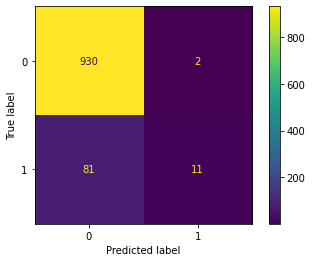

In [22]:
from sklearn.linear_model import LogisticRegression

lr_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    LogisticRegression()
)

lr_pipe.fit(X, y)
plot_confusion_matrix(lr_pipe, X_test, y_test)

### NB models

Complement Naive Bayes
Bernoulli Naive Bayes
Multinomial Naive Bayes


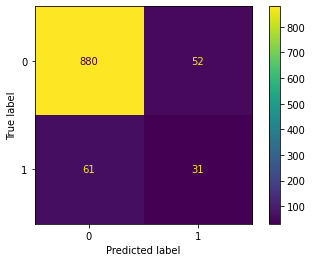

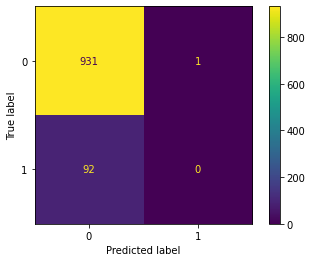

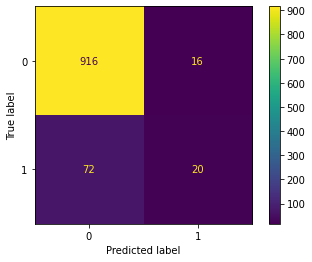

In [24]:
from sklearn.naive_bayes import ComplementNB, BernoulliNB, MultinomialNB

cnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    ComplementNB()
)

bnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    BernoulliNB()
)

mnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    MultinomialNB()
)

# fitting the models
cnb_pipe.fit(X, y)
print('Complement Naive Bayes')
plot_confusion_matrix(cnb_pipe, X_test, y_test)

bnb_pipe.fit(X, y)
print('Bernoulli Naive Bayes')
plot_confusion_matrix(bnb_pipe, X_test, y_test)

mnb_pipe.fit(X, y)
print('Multinomial Naive Bayes')
plot_confusion_matrix(mnb_pipe, X_test, y_test)

### Decision Tree

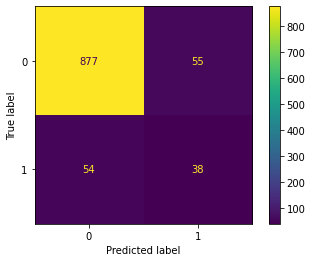

In [25]:
from sklearn.tree import DecisionTreeClassifier

dt_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    DecisionTreeClassifier()
)

dt_pipe.fit(X, y)
plot_confusion_matrix(dt_pipe, X_test, y_test)

### K-nearest neighbors

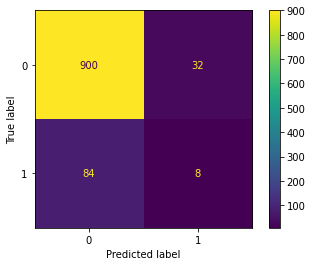

In [26]:
from sklearn.neighbors import KNeighborsClassifier

kn_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    KNeighborsClassifier()
)

kn_pipe.fit(X, y)
plot_confusion_matrix(kn_pipe, X_test, y_test)

### Perceptron

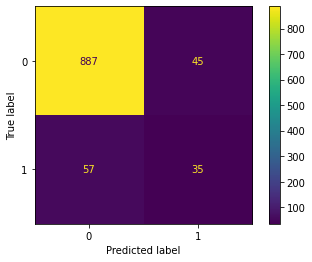

In [27]:
from sklearn.linear_model import Perceptron

p_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    Perceptron()
)

p_pipe.fit(X, y)
plot_confusion_matrix(p_pipe, X_test, y_test)

### Support Vector Machine

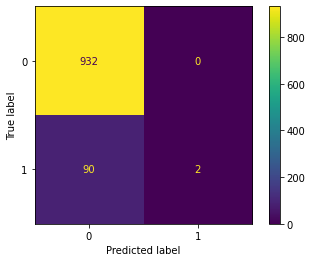

In [28]:
from sklearn.svm import SVC

svm_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    SVC()
)

svm_pipe.fit(X, y)
plot_confusion_matrix(svm_pipe, X_test, y_test)

## Comparing accuracy scores

In [29]:
scores = {
    'Logistic Regression': [accuracy_score(y_test, lr_pipe.predict(X_test))],
    'Complement NB': [accuracy_score(y_test, cnb_pipe.predict(X_test))],
    'Bernoulli NB': [accuracy_score(y_test, bnb_pipe.predict(X_test))],
    'Multinomail Regression': [accuracy_score(y_test, mnb_pipe.predict(X_test))],
    'K-nearest neighbors': [accuracy_score(y_test, kn_pipe.predict(X_test))],
    'Perceptron': [accuracy_score(y_test, p_pipe.predict(X_test))],
    'SVM': [accuracy_score(y_test, svm_pipe.predict(X_test))]
}

scores_df = pd.DataFrame.from_dict(scores)
scores_df

,Logistic Regression,Complement NB,Bernoulli NB,Multinomail Regression,K-nearest neighbors,Perceptron,SVM
0,0.918945,0.889648,0.90918,0.914062,0.886719,0.900391,0.912109


In [30]:
# the best accuracy
model_name = scores_df.idxmax(axis=1)[0]
f'{model_name} : {scores_df[model_name][0]}'

'Logistic Regression : 0.9189453125'